## 1. 扩散模型（Diffusion Model）

In [124]:
from IPython.display import Image, display
url = 'https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png'
display(Image(url=url, width=600))

分两个方向：

**正向过程（扩散过程）**：将原始数据（如图像）逐步添加高斯噪声，最终转化为纯噪声。每一步的噪声强度由预设的调度策略控制（如线性增加噪声）。这一过程是确定性的，不需要学习。

**逆向过程（去噪过程）**：模型通过训练学习如何逐步去除噪声，将纯噪声还原为原始数据。这是扩散模型的核心：通过神经网络（如U-Net）预测每一步的噪声，并迭代去噪。

## 2. 数学表达式

### 2.1 正向过程

将数据 $x_0$ 逐步添加高斯噪声，在T步之后，变为纯噪声 $x_T\sim\mathcal{N}(0,I)$  

假设从真实分布中取样 $x_0$ 服从某个分布 $x_0 \sim q(x)$  

$t$ 时刻的分布只取决于前一时刻 $t-1$ 的状态（马尔可夫性）  

$\beta_t$ 是 $t$ 时刻加入的噪声比例，预设的噪声调度参数（例如线性增长或余弦调度）    

$q(x_t|x_{t-1})=\mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_tI))$  

通过重参数化技巧，可以从 $x_0$ 直接计算任意 $t$ 时刻的 $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon,  \epsilon\sim\mathcal{N}(0,I)$

推导过程：  

$$x_t = \sqrt{1-\beta_t} x_{t-1} + \sqrt\beta_t\epsilon_{t-1} $$
$$=\sqrt{1-\beta_t}(\sqrt{1-\beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}}\epsilon_{t-2})+ \sqrt\beta_t\epsilon_{t-1}$$
$$=\sqrt{1-\beta_t}\sqrt{1-\beta_{t-1}} x_{t-2} + \sqrt{1-\beta_t}\sqrt{\beta_{t-1}}\epsilon_{t-2}+ \sqrt\beta_t\epsilon_{t-1}=\cdots$$
$$=\prod_{i=1}^t\sqrt{1-\beta_i}x_0 + \sqrt\beta_t\epsilon_{t-1} + \sqrt{1-\beta_t}\sqrt{\beta_{t-1}}\epsilon_{t-2} + \cdots $$

除第一项外，剩余项为n个标准正态分布的叠加，方差
$$\sigma^2=\beta_t+(1-\beta_t)\beta_{t-1}+\cdots$$
令$$\alpha_t=1-\beta_t$$
有
$$\sigma^2=1-\alpha_t+\alpha_t(1-\alpha_{t-1})+\cdots$$
$$=1-\prod_{i=1}^t\alpha_i$$ 
于是
$$x_t=\left(\prod_{i=1}^t(1-\beta_i) \right)^{1/2}x_0+\left(1-\prod_{i=1}^t(1-\beta_i)\right)^{1/2}\epsilon, \ \epsilon\sim\mathcal{N}(0,I)$$

定义$$\bar\alpha_t:=\prod_{i=1}^t(1-\beta_i)$$
表示前 $t$ 步累积的噪声保留率。

### 2.2 逆向过程

从噪声 $x_T\sim\mathcal{N}(0,I)$  逐步还原出原始数据 $x_0$

当$\beta_t$较小时，假设逆过程也是高斯的，于是 $q(x_{t-1}|x_t)$ 是高斯的。在给定 $x_0$ 的情况下，$q(x_{t-1}|x_t, x_0)$ 是有解析解的。

**根据 $x_0$ 已知程度的不同**，可以对应一些不同的应用场景。如果完全已知，则可以用来检验模型效果；若部分已知，如被遮挡，给定部分像素或 mask，条件扩散模型引导生成合理的其余图像部分；采用类似的图像，则可以生成具有相同风格/结构的新图像；如果给定的是图像所属类别标签，如"狗"、"猫"，模型从高斯噪声生成对应图像；也可以给定一段自然语言的描述，生成图像。

一般情况下这个分布很难计算，于是希望找到另外一个变分分布 $p_\theta$ 去迫近，也就是我们需要学习的模型。
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$
其中 $ \mu_\theta $ 和$  \Sigma_\theta  $是神经网络学习的均值和方差。这个过程类似于VAE

[Ho et al. (2020)](https://arxiv.org/pdf/2006.11239) 提出，只在每个时间步最小化：
$$\mathbb{E}_{x_0,\epsilon,t}\left[||\epsilon-\epsilon_\theta (x_t,t)||^2\right]$$
等价于对 ELBO 的近似优化。

从闭式采样中得到 $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$

将 $x_t$ 传入一个神经网络，训练其预测原始噪声, 得到预测结果 $\hat\epsilon$

直接采用MSE作为损失函数。 $L_t = \mathbb{E}_{x_0,\epsilon}\left[||\epsilon-\epsilon_\theta (\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon,t)||^2\right]$

有了预测噪声 $\hat\epsilon$，用其构造 $\hat x_0$ ，利用 $x_0$ 已知情况下 $q(x_{t-1}|x_t, x_0)$ 的闭式解公式来更新参数。

当 $x_0$ 已知时， $q(x_{t-1}|x_t, x_0)=\mathcal{N}(x_{t-1};\tilde{mu}(x_t,x_0),\tilde{\beta_t}I)$ 的闭式解为：
$$\tilde{\beta_t}=\frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\cdot \beta_t$$
$$\tilde{\mu}(x_t,x_0)=\frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}x_t+\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t}x_0$$

由预测噪声 $\hat\epsilon$ 得到 $$\hat x_0=\frac{1}{\sqrt{\bar\alpha_t}}(x_t - \sqrt{1-\bar\alpha_t}\hat\epsilon)$$

带入上式，有：
$${\mu}(x_t,x_0)=\frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}x_t+\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t}\hat x_0$$

### 2.3 隐状态空间

Latent Diffusion Model, LDM 就是让上述过程发生在隐状态空间内。[LDM](https://arxiv.org/pdf/2112.10752)

In [125]:
url = 'https://towardsdatascience.com/wp-content/uploads/2022/09/1WTe5olMSFC-T6No0Y_gKWg.png'
display(Image(url=url, width=600))

## 3. 简单实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.amp import autocast, GradScaler
from torchinfo import summary
import math
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from torchvision.utils import save_image, make_grid
import tqdm

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = 'data/MNIST/'
image_size = 28
batch_size = 128
channels = 1
timesteps = 1000
latent_dim = 64

In [73]:
mean=[0.1307]
std=[0.3081]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
dataset = datasets.MNIST(root='./data/', transform=transform, download='True', train=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

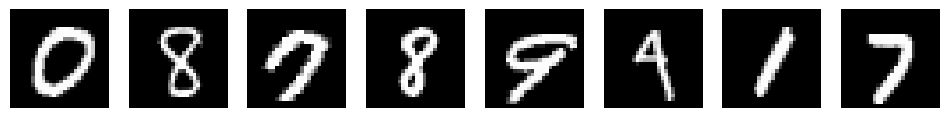

In [81]:
images, _ = next(iter(dataloader))  # images: [B, 1, 28, 28]
images = denormalize(images[:8], mean=[0.1307], std=[0.3081])
# 去通道维度并绘图
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(0).cpu(), cmap="gray")
    axes[i].axis("off")
plt.show()

In [28]:
# Time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim)
        self.act = nn.SiLU()

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return self.linear2(self.act(self.linear1(emb)))

In [29]:
# Residual block with time embedding
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.residual(x)

In [30]:
# Self-Attention block (for 2D images)
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv1d(channels, channels, 1)
        self.k = nn.Conv1d(channels, channels, 1)
        self.v = nn.Conv1d(channels, channels, 1)
        self.proj = nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = self.norm(x).view(B, C, H * W)  # [B, C, HW]
        q, k, v = self.q(x_), self.k(x_), self.v(x_)

        attn = torch.softmax(q.transpose(1, 2) @ k / math.sqrt(C), dim=-1)
        out = v @ attn.transpose(1, 2)  # [B, C, HW]
        out = self.proj(out).view(B, C, H, W)
        return out + x

In [55]:
# UNet with Conv down/up and center attention
class UNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_emb_dim)

        self.enc1 = ResBlock(1, 32, time_emb_dim)
        self.down1 = nn.Conv2d(32, 64, 4, 2, 1)  # downsample
        self.enc2 = ResBlock(64, 64, time_emb_dim)

        self.mid = nn.Sequential(
            ResBlock(64, 64, time_emb_dim),
            AttentionBlock(64),
            ResBlock(64, 64, time_emb_dim)
        )

        self.up1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)  # upsample
        self.dec1 = ResBlock(32, 32, time_emb_dim)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down1(x1), t_emb)
        
        # 修改点：传递 t_emb 给 mid
        x_mid = self.mid[0](x2, t_emb)  # ResBlock
        x_mid = self.mid[1](x_mid)      # AttentionBlock
        x_mid = self.mid[2](x_mid, t_emb)  # ResBlock

        x_up = self.dec1(self.up1(x_mid), t_emb)
        return self.out(x_up)

In [56]:
from copy import deepcopy
# EMA Tracker
class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = deepcopy(model)
        self.model.eval()
        self.decay = decay

    def update(self, model):
        with torch.no_grad():
            for p_ema, p in zip(self.model.parameters(), model.parameters()):
                p_ema.data.mul_(self.decay).add_(p.data, alpha=1 - self.decay)

In [57]:
# 创建 beta 调度器（线性或 cosine 可选）
def make_beta_schedule(schedule='linear', timesteps=1000, s=0.008):
    if schedule == 'linear':
        beta_start = 1e-4
        beta_end = 0.02
        return torch.linspace(beta_start, beta_end, timesteps)
    elif schedule == 'cosine':
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

In [83]:
# 扩散类
class Diffusion:
    def __init__(self, timesteps=1000, beta_schedule='cosine', device='cuda'):
        self.timesteps = timesteps
        self.betas = make_beta_schedule(beta_schedule, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
        self.device = device

    # q(x_t | x_0)
    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_hat * x_0 + sqrt_one_minus * noise

    # 标准反向采样过程 p(x_{t-1} | x_t)
    def p_sample(self, model, x, t):
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)

        eps_pred = model(x, t)
        mean = (1 / alpha_t.sqrt()) * (x - (beta_t / sqrt_one_minus_alpha) * eps_pred)
        noise = torch.randn_like(x) if (t > 0).all() else 0
        return mean + noise * beta_t.sqrt()

    # 完整采样流程
    def p_sample_loop(self, model, shape):
        x = torch.randn(shape).to(self.device)
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            x = self.p_sample(model, x, t_batch)
        return x

    # DDIM sampling（可调 eta）
    def ddim_sample(self, model, shape, eta=0.0, steps=50):
        times = torch.linspace(0, self.timesteps - 1, steps).long().to(self.device)
        alphas = self.alpha_hat[times]

        x = torch.randn(shape).to(self.device)

        for i in reversed(range(steps)):
            t = times[i].repeat(shape[0])
            alpha = alphas[i].view(-1, 1, 1, 1)
            eps = model(x, t)

            x0_pred = (x - eps * (1 - alpha).sqrt()) / alpha.sqrt()
            if i > 0:
                alpha_prev = alphas[i - 1].view(-1, 1, 1, 1)
                sigma = eta * ((1 - alpha_prev) / (1 - alpha) * (1 - alpha / alpha_prev)).sqrt()
                noise = torch.randn_like(x)
                x = alpha_prev.sqrt() * x0_pred + (1 - alpha_prev).sqrt() * eps + sigma * noise
            else:
                x = x0_pred
        return x

In [90]:
# 可视化保存路径
def save_samples(samples, step, path="./images/"):
    os.makedirs(path, exist_ok=True)
    save_image(samples, os.path.join(path, f"{step:04d}.png"), nrow=8, normalize=True)

# 训练函数
def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 模型 & EMA
    model = UNet().to(device)
    ema = EMA(model)
    diffusion = Diffusion(device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

    epochs = 400
    for epoch in range(epochs):
        pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch}")
        for i, (x, _) in enumerate(pbar):
            x = x.to(device)
            t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()
            noise = torch.randn_like(x)
            x_t = diffusion.q_sample(x, t, noise)

            loss = F.mse_loss(model(x_t, t), noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            ema.update(model)

            pbar.set_postfix(loss=loss.item())

        # 采样并保存
        if epoch % 5 == 0:
            with torch.no_grad():
                samples = diffusion.p_sample_loop(ema.model, (64, 1, 28, 28))
                samples = samples.clamp(0, 1)
                samples = denormalize(samples, mean=[0.1307], std=[0.3081])
                save_samples(samples, epoch)

In [91]:
train()

Epoch 399: 100%|████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.28it/s, loss=0.0504]


In [105]:
torch.save({
    'model_state_dict': model.state_dict(),
    'ema_state_dict': ema.model.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 400
}, './model_pkl/mnist_diffusion_final.pth')

In [110]:
# 保存多个中间步骤图像
def visualize_denoising(diffusion, model, shape, save_dir="./images", steps=20):
    os.makedirs(save_dir, exist_ok=True)
    x = torch.randn(shape).to(diffusion.device)
    indices = torch.linspace(0, diffusion.timesteps - 1, steps).long()

    with torch.no_grad():
        for i, t in enumerate(reversed(indices)):
            t_batch = torch.full((shape[0],), t.item(), dtype=torch.long).to(diffusion.device)
            x = diffusion.p_sample(model, x, t_batch)
            out = (x.clamp(-1, 1) + 1) / 2
            out = denormalize(out, mean, std)
            save_image(out, os.path.join(save_dir, f"step_{i:02d}.png"), nrow=8)

In [113]:
model = UNet().to(device)
ema = EMA(model, decay=0.9999)
checkpoint = torch.load('./model_pkl/mnist_diffusion_final.pth', map_location='cpu', weights_only=False)
ema.model.load_state_dict(checkpoint['ema_state_dict'])
ema.model.eval()
diffusion = Diffusion(timesteps=1000, beta_schedule='cosine', device='cuda')
visualize_denoising(diffusion, ema.model, (64, 1, 28, 28))